In [8]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
# Prepare the data

train_files = glob.glob("../dataset/train/*.csv")
data = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)

#sort by time
data = data.sort_values(by="time")
print(data.head())

# Use only el_power for forecasting\
series = data[["el_power"]].values

print(series[:2])

# scale between 0 & 1
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

print("series_scaled:" ,series_scaled[:2])

            time  input_voltage     el_power
22910  810.00000            3.0  1102.949693
0      810.07028           10.0  1228.791720
32098  811.04000            3.0  1217.413110
22911  811.04000            3.0  1199.403786
1      811.06938           10.0  1223.041745
[[1102.94969345]
 [1228.79172023]]
series_scaled: [[0.07341755]
 [0.12772877]]


In [ ]:
# Create sequences for LSTM

def create_Seq(data, window_size):
    X = []
    y = []
    
    print("original data shape:", data.shape)
    #print(data[:5], len(data))
    
    for i in range(window_size, len(data)):
        
        X.append(data[i-window_size:i])
        y.append(data[i])
        
    return np.array(X), np.array(y)

WINDOW_SIZE = 20

X, y = create_Seq(series_scaled, WINDOW_SIZE)
print("X shape:", X.shape)
print("y shape:", y.shape)



original data shape: (52940, 1)
X shape: (52920, 20, 1)
y shape: (52920, 1)


In [4]:
# Train/Test Split

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
# Build LSTM Model\

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()

model_lstm.add(LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE,1)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1))

model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_lstm.summary()


c:\Work\MS-AI\course-7\Project\IoT_Gas_Turbine\course7_Project_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model

history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0588 - mae: 0.1851 - val_loss: 0.0464 - val_mae: 0.1801
Epoch 2/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0441 - mae: 0.1555 - val_loss: 0.0723 - val_mae: 0.2202
Epoch 3/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0402 - mae: 0.1438 - val_loss: 0.0821 - val_mae: 0.2275
Epoch 4/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.0376 - mae: 0.1362 - val_loss: 0.0427 - val_mae: 0.1714
Epoch 5/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0348 - mae: 0.1292 - val_loss: 0.1004 - val_mae: 0.2418
Epoch 6/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0336 - mae: 0.1256 - val_loss: 0.0681 - val_mae: 0.2028
Epoch 7/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0327 - mae: 0.1232 - val_loss: 0.1107 - val_mae: 0.2553
Epoch 8/20
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0320 - mae: 0.1207 - val_loss: 0.1041 - val_mae: 0.2593
Epoch 9/20
1059/1059 ━━━━━━

In [9]:
# Evaluate the model

loss, mae = model_lstm.evaluate(X_test, y_test)
print("Test MSE Loss:", loss)
print("Test MAE:", mae)

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0555 - mae: 0.1827
Test MSE Loss: 0.055521123111248016
Test MAE: 0.1826833039522171


In [11]:
# Convert predictions back to original scale

predictions = model_lstm.predict(X_test)

# Inverse scale
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


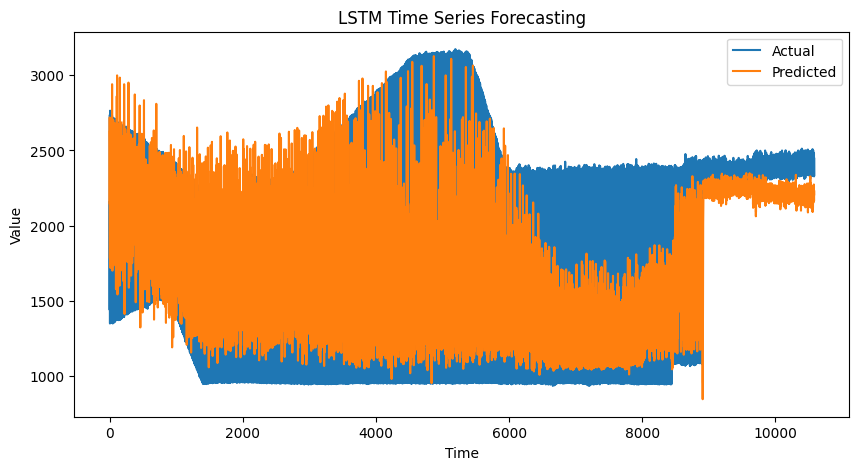

In [12]:
# Visualization

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Time Series Forecasting')
plt.legend()
plt.show()

In [ ]:
# Save predictions to CSV for Tableau visualization

lstm_results = pd.DataFrame({
    "Actual_el_power": y_test_inv.flatten(),
    "Predicted_el_power": predictions_inv.flatten()
})

lstm_results.to_csv("lstm_test_predictions.csv", index=False)

print("Saved LSTM predictions.")

Saved LSTM predictions.
